# Preprocessing of CM2.6 input for air-sea flux calculation


In [1]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cm26_utils import load_and_combine_cm26
from utils import smooth_inputs
from scale_aware_air_sea.utils import to_zarr_split

# set up gcs filesystem
# 👇 replace with your key 
with open('/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

# with dask.config.set({'optimization.fuse.ave-width': 21, 'optimization.fuse.max-height': 30}):
    # ds_merged  = load_and_combine_cm26(fs)
ds_merged  = load_and_combine_cm26(fs, inline_array=False)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [2]:
# d = ds_merged.surface_temp.isel(time=slice(0,9)).data
# d.visualize(optimize_graph=True)

In [3]:
# d = ds_merged.t_ref.isel(time=slice(0,9)).data
# d.visualize(optimize_graph=True)

In [4]:
# d = ds_merged.u_relative.isel(time=slice(0,9)).data
# d.visualize(optimize_graph=True)

## Smooth input fields

In [5]:
filter_scale = 50

smooth_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp']
for var in smooth_vars:
    var_wet_mask = (~np.isnan(ds_merged[var].isel(time=0))).astype(int) # build wet mask for each variable separately from first timestep
    ds_merged[var+'_smoothed'] = smooth_inputs(ds_merged[var], var_wet_mask, ['xt_ocean', 'yt_ocean'], filter_scale)
ds_merged

<xarray.Dataset>
Dimensions:                (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                   (time) object 0181-01-01 12:00:00 ... 0200-12-31 1...
  * xt_ocean               (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * yt_ocean               (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
Data variables: (12/17)
    slp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind                   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                     ...
    u_relative_smoothed    (time, xt_ocean, yt_ocean) float32 dask.array<chunksize=(3, 3600, 2700), meta=np.ndarray>
    v_relative_smoothed    (time, xt_ocean, yt_ocean) float32 dask.array<chunksize=(3, 3600, 2700), meta=np.ndarray>
    surface_temp_smoothed  (time, xt_ocean, yt_ocean) float32 dask.array<chunksize=(3, 3600, 2700), meta=np.ndarray>
    t_ref_smoothed         (time, xt_ocean, yt_ocean) float32 dask.array<chunksize=(3, 3600, 2700), meta=np.ndarray>
    q_ref_smoothed         (time, xt_ocean, yt_ocean) float32 dask.array<chunksize=(3, 3600, 2700), meta=np.ndarray>
    slp_smoothed           (time, xt_ocean, yt_ocean) float32 dask.array<chunksize=(3, 3600, 2700), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

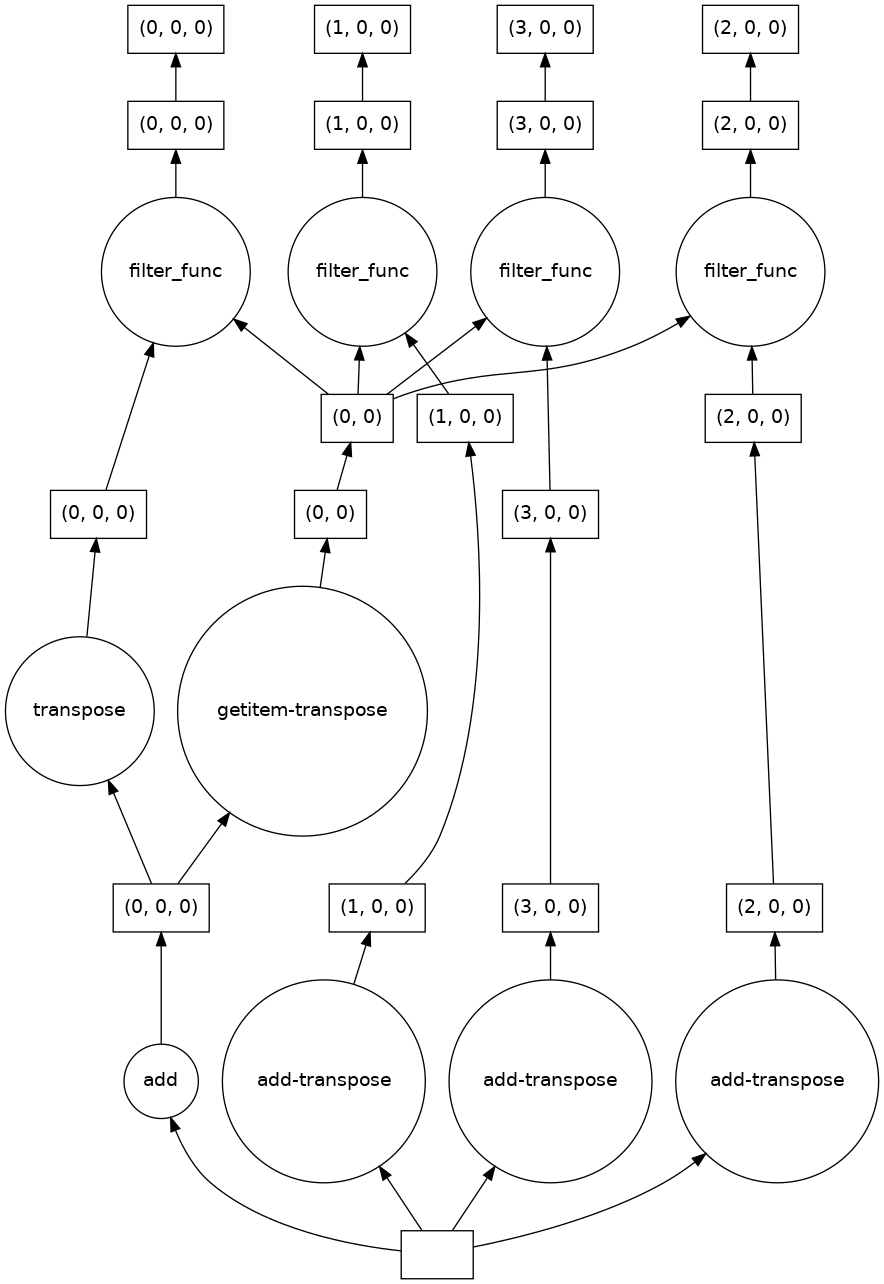

In [6]:
d = ds_merged.surface_temp_smoothed.isel(time=slice(0,12)).data
d.visualize(optimize_graph=True)

# Some sanity checks with the data before large batch save

In [7]:
# # check outputs (these should look very similar, since ocean velocities << atmos velocities in most places
# ds_wind = ds_merged.isel(time=20)
# fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[14,6])
# for var, ax in zip(['u_ref', 'u_relative', 'v_ref', 'v_relative'], axarr.flat):
#     ds_wind[var].plot(robust=True, x='xt_ocean', ax=ax)

In [8]:
# ds_sample_full = ds_merged.isel(time=[0,120]).load()

In [9]:
# ds_sample = ds_sample_full.isel(xt_ocean=slice(1000, 2700), yt_ocean=slice(0, 1500))
# # Check that these dont show any artifacts or large scale features
# plot_kwargs = {'x':'xt_ocean', 'robust':True}
# for var in smooth_vars:
#     print(var)
#     fig, axarr = plt.subplots(nrows=len(ds_sample.time), ncols=3, figsize=[25,10])
#     for tt in range(len(ds_sample.time)):
#         print(tt)
#         axarr_sub = axarr[tt, :].flat
#         raw = ds_sample[var].isel(time=tt)
#         smoothed = ds_sample[var+'_smoothed'].isel(time=tt)
#         diff = raw - smoothed
        
#         # unsmoothed result
#         raw.plot(ax=axarr_sub[0], **plot_kwargs)
        
#         # smoothed result
#         smoothed.plot(ax=axarr_sub[1], **plot_kwargs)
        
#         # difference
#         diff.plot(ax=axarr_sub[2], **plot_kwargs)
#     plt.show()

In [10]:
# client.shutdown()
# client.close

In [11]:
# prune dataset for saving
keep_vars = ['slp_smoothed', 'surface_temp_smoothed', 'u_relative_smoothed',
             'v_relative_smoothed', 't_ref_smoothed', 'q_ref_smoothed']
# keep_vars = ['surface_temp_smoothed']
ds_save = ds_merged[keep_vars]

In [12]:
# save out
path = 'ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_split_v2.zarr'
mapper = fs.get_mapper(path)

In [13]:
# I cannot freaking get a cluster anymore?

## Set up a legit dask cluster

In [14]:
# hacky stuff (but it works!)
n_workers = 100
n_threads = 10 # I think 12 is the max?
# with time chunks as 3 this needs to be set down. 4 seemed to work but had some memory to spare.

# distributed does not like these long tasks (>40s) we produce. 
# Lets see if we can tune that (!YES!):
import dask
dask.config.set(
    {
        "distributed.comm.timeouts.tcp": "240s",
        "distributed.comm.timeouts.connect": "240s",
    }
)

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
# options.worker_memory = 32  # I think somewhere around this (52 previously) is the max per pod?
options.worker_memory = 50
options.worker_cores = n_threads 

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.scale(n_workers)
client

[]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.a71eca871af040f39879c3078c92e2de/status,


In [15]:
if mapper.fs.exists(mapper.root):
    print(f'removing {mapper.root}')
    mapper.fs.rm(mapper.root, recursive=True)

removing ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_split_v2.zarr


In [16]:
# # This should work...
# ds_save.to_zarr(mapper, mode='w', consolidated=True)
# # ds_save.isel(time=slice(0,500)).to_zarr(mapper, mode='w', consolidated=True)

# But it doesnt so lets see how this fares:
to_zarr_split(ds_save, mapper, split_interval=600) #split

  0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
%%time
ds = xr.open_dataset(mapper, engine='zarr', chunks={}, consolidated=True)

CPU times: user 71.5 ms, sys: 2.01 ms, total: 73.5 ms
Wall time: 266 ms


2022-10-30 19:44:40,591 - distributed.client - ERROR - Exception raised while shutting down cluster prod.a71eca871af040f39879c3078c92e2de
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 994, in _stop_internal
    await self.gateway._stop_cluster(self.name)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 655, in _stop_cluster
    await self._request("DELETE", url)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 397, in _request
    resp = await session.request(method, url, json=json, **self._request_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/aiohttp/client.py", line 536, in _request
    conn = await self._connector.connect(
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/aiohttp/connector.py", line 540, in connect
    proto = await self._create_connection(req, traces, timeout)
  File "/s

In [18]:
raise

RuntimeError: No active exception to reraise

# Fin

In [ ]:
from aerobulk import skin, noskin

ds_out = xr.Dataset()
ds_out['ql'], ds_out['qh'], ds_out['taux'], ds_out['tauy'], ds_out['evap'] =  noskin(
    ds_merged.surface_temp,
    ds_merged.t_ref,
    ds_merged.q_ref,
    ds_merged.u_relative,
    ds_merged.v_relative,
    slp=ds_merged.slp,
    algo=algo,
    zt=2,
    zu=10,
    input_range_check=False
)

In [ ]:
ds_out

## a quick comparison with absolute vs relative wind

In [ ]:
from aerobulk import skin, noskin
from dask.diagnostics import ProgressBar

ds_out_absolute = xr.Dataset()
(
    ds_out_absolute['ql'],
    ds_out_absolute['qh'],
    ds_out_absolute['taux'],
    ds_out_absolute['tauy'],
    ds_out_absolute['evap'],
) =  noskin(
    ds_merged.surface_temp,
    ds_merged.t_ref,
    ds_merged.q_ref,
    ds_merged.u_ref,
    ds_merged.v_ref,
    slp=ds_merged.slp,
    algo=algo,
    zt=2,
    zu=10,
    input_range_check=False
)

tt = 20
ds_comparison = xr.concat([ds_out.isel(time=tt), ds_out_absolute.isel(time=tt)], dim='method')

with ProgressBar():
    ds_comparison = ds_comparison.load()

In [ ]:
for (var, vmax_abs) in [('ql', 200), ('qh', 100), ('taux', 0.2), ('tauy', 0.2), ('evap', 1e-4)]:
    print(var)
    vmax_diff = vmax_abs * 0.05
    plt.figure()
    ds_comparison[var].plot(col='method', x='xt_ocean', vmax=vmax_abs)
    plt.figure()
    (ds_comparison.diff('method'))[var].plot(x='xt_ocean', vmax=vmax_diff)
    plt.show()

## Degrade the resolution

In [ ]:
import gcm_filters
# wet_mask = ds_oc_grid.wet.load().astype(int)
wet_mask = (~np.isnan(ds_merged.surface_temp.isel(time=0))).astype(int)
simple_filter = gcm_filters.Filter(
    filter_scale=40, # takes longer for larger filter scale! Is 20 enough?
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)

In [ ]:
wet_mask.plot()

In [ ]:
# # is the wet mask proper
# (~wet_mask & ~np.isnan(ds_merged.surface_temp.isel(time=0))).plot()

In [ ]:
# with ProgressBar():
#     ds_tofilter = ds_merged.isel(time=10).load()
#     da_filtered = simple_filter.apply(ds_tofilter.surface_temp, dims=['yt_ocean', 'xt_ocean']).load()

In [ ]:
ds_tofilter = ds_merged
da_filtered = simple_filter.apply(ds_tofilter.surface_temp, dims=['yt_ocean', 'xt_ocean'])

In [ ]:
with ProgressBar():
    da_filtered.isel(time=10).plot(robust=True, x='xt_ocean')

In [ ]:
with ProgressBar():
    ds_merged.surface_temp.isel(time=10).plot(robust=True, x='xt_ocean')

In [ ]:
with ProgressBar():
    (ds_merged.surface_temp.isel(time=10) - da_filtered.isel(time=10)).plot(robust=True, x='xt_ocean')